# Regularized least squared problem with kernels from bottom up

### import libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler
from numpy.random import randn

### General system for damped oscilator

$
\ddot{x}(t) + 2\zeta\omega_0 \dot{x}(t) + \omega_0^2 x(t) = 0
$

#### Description of variables:
- $ x(t) $: position 
- $ \dot{x}(t) $: Velocity 
- $ \ddot{x}(t) $: acceleration
- $ \zeta $: The damping factor, which determines how quickly the oscillations decay (due to friction or resistance).
- $ \omega_0 $: The natural frequency of the system (eigenfrequency)
- $ t $: Time unit.

In [23]:
def damped_oscillator(t, y):  #remember that independent value t comes first
    zeta = 1*0.2/np.sqrt(2)
    omega_0 = 0.2* 2* np.pi
    y_dot = - 2* zeta * omega_0 * y[1] - omega_0**2 * y[0] # x'' = -2*z*w0*x' - w0^2 * x rewritten as a system of first order 
    return [y[1], y_dot]  #y[1] = velocity and y_dot = acceleration. return both since system is rewritten as 2 first order diffs.

### solving the differential equation numerically with scipy

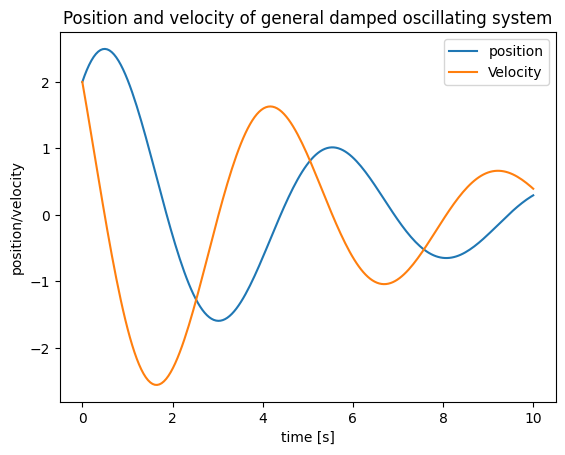

In [24]:
t_eval = np.linspace(0, 10, 200)
init_condition = [2, 2]  # Initial condition [position, velocity]
sol = solve_ivp(damped_oscillator, (0, 10), init_condition, t_eval = t_eval)#time interval first, then initial values for position and velocity
x,y  = sol.y        #sol.y contains solutions for position and velocity calculated over t_eval as a 2d array

plt.plot(t_eval, x, label = "position")
plt.plot(t_eval, y, label = "Velocity")
plt.xlabel("time [s]")
plt.ylabel("position/velocity")
plt.title("Position and velocity of general damped oscillating system")
plt.legend()
plt.show()

### Phase plot of the oscilator

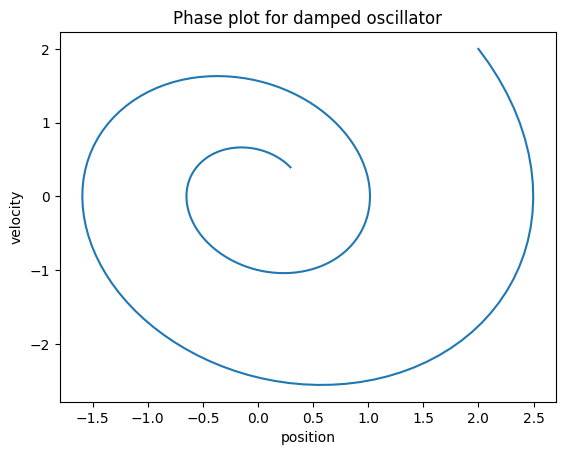

In [25]:
plt.plot(x, y)
plt.xlabel("position")
plt.ylabel("velocity")
plt.title("Phase plot for damped oscillator")
plt.show()

### Discretizing the dataset for with gaussian noise

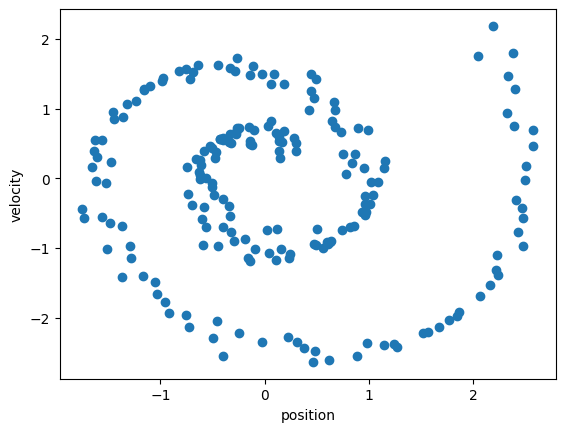

In [26]:
p = x[::]
v = y[::]
def generate_noisy_data(p, v, t, noise_std=0.1):
    gaussian_noise = np.random.normal(0, noise_std, len(p))
    # Add noise to position, velocity, and acceleration
    p_noisy = p + gaussian_noise
    v_noisy = v + gaussian_noise
    
    input_data = np.column_stack((t, p_noisy))
    target_outputs = v_noisy
    
    return input_data, target_outputs
    
input_data, target_outputs = generate_noisy_data(p, v, t_eval, noise_std=0.1)
plt.plot(input_data[:,1], target_outputs, 'o')
plt.xlabel("position")
plt.ylabel("velocity")
plt.show()


### Standardize the data

#### Tuning of $𝜆$ and $𝛼$
 - Lambda ($𝜆$): This is the regularization parameter that controls the trade-off between minimizing error on the training data and keeping the model complexity low. Higher $𝜆$ values apply stronger regularization, leading to simpler, smoother solutions that generalize better.

 - Sigma ($𝜎$): In the RBF kernel, $𝜎$, controls the spread of the kernel, defining how quickly similarity decays with distance. Smaller 
$𝜎$ results in a highly localized influence (risking overfitting), whereas larger $𝜎$ smooths the influence over a broader area (which may underfit).

### Computing the gassian kernel matrix

In [27]:
sigma, lam = [10, 0.0001]
def rbfkernel(x, z, sigma):
    k = np.exp(-(np.linalg.norm(x - z)**2)/(2 * sigma**2))
    return k

def gram(x_list, z_list, sigma):
    n = len(x_list)
    k_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            k_mat[i,j] = rbfkernel(x_list[i], z_list[j], sigma)
    return k_mat
    
K = gram(input_data, input_data, sigma)

### Solve the minimization problem to obtain dual coefficients $a$

In [28]:
def dual_coeff(K, y, lambd):
    n = K.shape[0]
    K_reg = K + lambd * np.eye(n)
    alpha = np.linalg.solve(K_reg, y)
    return alpha
alpha = dual_coeff(K, target_outputs, lam)  #1D column vector


### Estimate the function based on $a$ and kernel matrix

In [29]:
def f(a, x):
    # Ensure x is a 1D array
    x = np.atleast_1d(x)
    n = x.shape[0]
    f = np.zeros(n)
    for i in range(n):
        tot = 0
        for j in range(len(a)):  # Use the length of coefficients 'a'
            tot += a[j] * rbfkernel(x[i], x[j], sigma)
        f[i] = tot
    return f
f_estimate = f(alpha, input_data)
f_estimate

array([ 2.84228649e-02, -4.75281367e-01,  4.86575340e-01,  2.60198794e-01,
        4.07375354e-01,  1.14053232e-01,  2.41571574e-01,  6.49939431e-01,
        5.62950897e-01,  3.43586708e-01,  2.53490164e-01,  7.43236914e-04,
        6.81665786e-02,  4.73534318e-02, -9.88963943e-02, -5.44208515e-01,
       -1.14342199e-01, -6.17931261e-01, -6.10894915e-01, -7.69326429e-01,
       -9.45851398e-01, -1.26631142e+00, -1.40135615e+00, -1.28863790e+00,
       -1.51076918e+00, -1.62886482e+00, -1.66501867e+00, -1.93277766e+00,
       -1.91159418e+00, -1.96869278e+00, -2.18235666e+00, -2.02445708e+00,
       -2.29925015e+00, -2.35197204e+00, -2.24052468e+00, -2.23448739e+00,
       -2.19107786e+00, -2.15465188e+00, -2.21760789e+00, -2.33565579e+00,
       -2.12020831e+00, -2.14215131e+00, -1.99332617e+00, -1.99781206e+00,
       -1.87793593e+00, -1.81198669e+00, -1.69091706e+00, -1.58517419e+00,
       -1.45661110e+00, -1.35409213e+00, -1.27221417e+00, -1.11455555e+00,
       -9.84588900e-01, -

### plot results

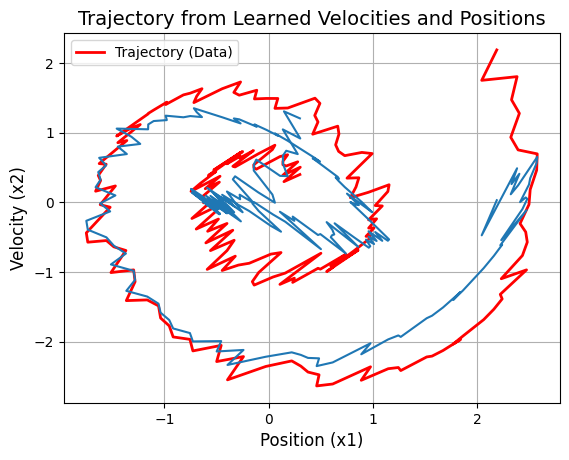

In [30]:

# Plot the estimated velocity
plt.plot(input_data[:,1], target_outputs, 'r-', label="Trajectory (Data)", linewidth=2)
plt.plot(input_data[:,1], f_estimate)
# Add labels and legend
plt.title("Trajectory from Learned Velocities and Positions", fontsize=14)
plt.xlabel("Position (x1)", fontsize=12)
plt.ylabel("Velocity (x2)", fontsize=12)
plt.legend()
plt.grid()
plt.show()
